In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [8]:
# doc du lieu tu pandas
import pandas as pd 
df = pd.read_csv('C:/Users/admin/Documents/Python Scripts/logistic regression/hmeq.csv', header = 0, sep = ',')
df.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


number of numeric field:  9


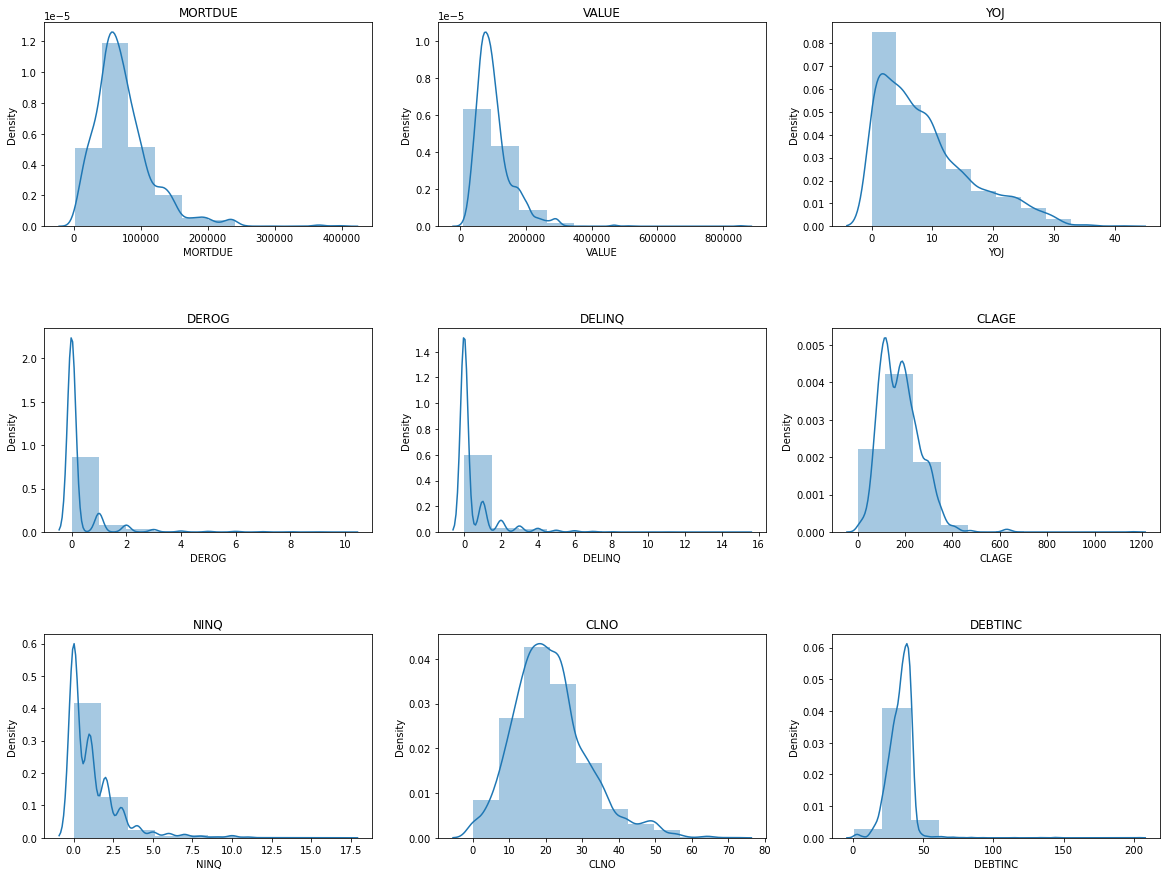

In [9]:
import seaborn as sns
import warnings
warnings.simplefilter(action = 'ignore', category= FutureWarning)
numeric_cols = df.select_dtypes(include = ['float','int']).columns

def _plot_numeric_classes(df,col,bins =  10, hist = True, kde = True):
    sns.distplot(df[col], bins = bins, hist = hist, kde = kde)
    
def _distribution_numeric(df,numeric_cols, row=3, col=3, figsize=(20, 15), bins = 10):
    print('number of numeric field: ', len(numeric_cols))
    assert row*(col-1) < len(numeric_cols)
    plt.figure(figsize = figsize)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
    for i in range(1, len(numeric_cols)+1, 1):
      try:
        plt.subplot(row, col, i)
        _plot_numeric_classes(df, numeric_cols[i-1], bins = bins)
        plt.title(numeric_cols[i-1])
      except:
        print('Error {}'.format(numeric_cols[i-1]))
        break

_distribution_numeric(df, numeric_cols)

number of category field:  2


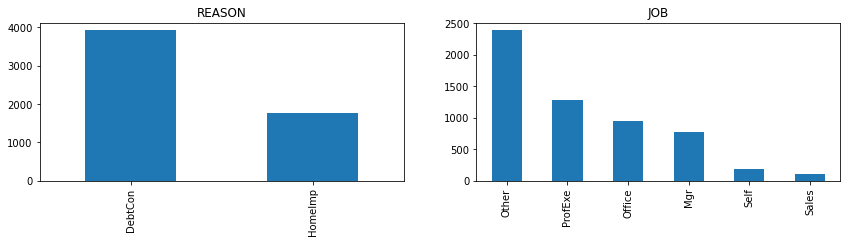

In [10]:
cate_cols = df.select_dtypes('O').columns
def _plot_bar_classes(df, cols):
    df[cols].value_counts().plot.bar()
    
def _distribution_cate(df, cate_cols, row = 1, col = 2, figsize = (20, 5)):
  print('number of category field: ', len(cate_cols))
  plt.figure(figsize = figsize)
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)    
  for i in range(1, len(cate_cols)+1, 1):
    try:
      plt.subplot(row, col, i)#subplot ve nhieu o trong 1 hinh
      _plot_bar_classes(df, cate_cols[i-1])
      plt.title(cate_cols[i-1])
    except:
      break
   
_distribution_cate(df, cate_cols, row = 4, col = 4, figsize = (30, 16))

In [34]:
# train/test the ti le 80:20
df_train, df_test = train_test_split(df, test_size = 0.2,stratify = df['BAD'])
X_train =df_train.copy()

y_train = X_train.pop("BAD")
X_test = df_test.copy()
y_test = X_test.pop("BAD")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4768, 12) (4768,)
(1192, 12) (1192,)


In [13]:
# Lấy list names của các biến phân loại và biến liên tục.
cat_names = list(X_train.select_dtypes('object').columns)
num_names = list(X_train.select_dtypes(['float', 'int']).columns)

In [14]:
# Pipeline xử lý cho biến phân loại
cat_pl= Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # Xử lý missing data bằng cách thay thế most frequent
        ('onehot', OneHotEncoder()), # Biến đổi giá trị của biến phân loại thành véc tơ OneHot
    ]
)

In [18]:
# Pipeline xử lý cho biến liên tục
num_pl = Pipeline(
    steps=[
           ('imputer', KNNImputer(n_neighbors=7)), # Xử lý missing data bằng cách dự báo KNN với n=7.
           ('scaler', MinMaxScaler()) # Xử lý missing data bằng MinMax scaler
    ]
)

In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pl, num_names), # áp dụng pipeline cho biến liên tục
        ('cat', cat_pl, cat_names), # áp dụng pipeline cho biến phân loại
    ]
)

In [24]:
LogisticRegression(penalty='l2',
tol=0.0001, 
C=1.0, 
fit_intercept=True, 
class_weight=None, 
solver='lbfgs', 
max_iter=100)

LogisticRegression()

In [28]:
# Completed training pipeline
completed_pl = Pipeline(
    steps=[
            ("preprocessor", preprocessor), 
            ("classifier", LogisticRegression(penalty='l2', C=0.5, max_iter=200, class_weight=[0.3, 0.7]))
    ]
)

# training
completed_pl.fit(X_train, y_train)

# accuracy
y_train_pred = completed_pl.predict(X_train)
print(f"Accuracy on train: {accuracy_score(list(y_train), list(y_train_pred)):.2f}")

y_pred = completed_pl.predict(X_test)
print(f"Accuracy on test: {accuracy_score(list(y_test), list(y_pred)):.2f}")

Accuracy on train: 0.82
Accuracy on test: 0.82
